<a href="https://colab.research.google.com/github/sanzidarahman1/ENGG_680_Project/blob/main/LSTM_WB_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.feature_selection import mutual_info_regression

# Load the data
train_val_file_path = 'train and validation_WB.xlsx'
test_file_path = 'test_WB.xlsx'

train_val_data = pd.read_excel(train_val_file_path)
test_data = pd.read_excel(test_file_path)

# Combine datasets for preprocessing consistency
data = pd.concat([train_val_data, test_data]).sort_values(by=['date', 'time']).reset_index(drop=True)

# Convert date and time columns
data['date'] = pd.to_datetime(data['date'])
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.time

# Extract additional time features
data['hour'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.hour
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.weekday
data['day_of_year'] = data['date'].dt.dayofyear

# Encode categorical variables
data['weekend/holiday (y/n)'] = data['weekend/holiday (y/n)'].map({'y': 1, 'n': 0})
data['stampede (y/n)'] = data['stampede (y/n)'].map({'y': 1, 'n': 0})
data = pd.get_dummies(data, columns=['day type'], prefix='DayType')

# Add lagged weather features
data['temp_lag'] = data['temp. (C)'].shift(1).fillna(0)
data['precip_lag'] = data['daily precip. (mm)'].shift(1).fillna(0)
data['wind_lag'] = data['wind (km/h)'].shift(1).fillna(0)

# Normalize numeric features
scaler = MinMaxScaler()
features = ['vehicle count', 'temp. (C)', 'daily precip. (mm)', 'wind (km/h)', 'hour', 'month', 'day_of_week',
            'day_of_year', 'temp_lag', 'precip_lag', 'wind_lag', 'weekend/holiday (y/n)', 'stampede (y/n)'] + \
           [col for col in data.columns if 'DayType_' in col]
data[features] = scaler.fit_transform(data[features])

# Separate training/validation and test datasets
train_val_data = data.iloc[:-len(test_data)]  # First 10 months
test_data = data.iloc[-len(test_data):]       # Last 2 months


In [4]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Ensure a copy of the DataFrame is made to avoid warnings
train_val_data_copy = train_val_data.copy()

# Preprocess 'date' and 'time' into numeric features
train_val_data_copy['day'] = train_val_data_copy['date'].dt.day
train_val_data_copy['month'] = train_val_data_copy['date'].dt.month
train_val_data_copy['year'] = train_val_data_copy['date'].dt.year
train_val_data_copy['hour'] = pd.to_datetime(train_val_data_copy['time'], format='%H:%M:%S').dt.hour

# Drop non-numeric and irrelevant columns
X = train_val_data_copy.drop(columns=['vehicle count', 'date', 'time'])
y = train_val_data_copy['vehicle count']

# Ensure X contains only numeric data
X = X.select_dtypes(include=['number'])

# Calculate mutual information
mutual_info = mutual_info_regression(X, y)

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': mutual_info
}).sort_values(by='Importance', ascending=False)

# Select top features
selected_features = feature_importance.nlargest(8, 'Importance')['Feature'].tolist()
print("Selected Features Based on Mutual Information:", selected_features)

# Display feature importance
print("Feature Importance Based on Mutual Information:")
print(feature_importance)


Selected Features Based on Mutual Information: ['hour', 'temp. (C)', 'temp_lag', 'day_of_year', 'day_of_week', 'weekend/holiday (y/n)', 'daily precip. (mm)', 'wind (km/h)']
Feature Importance Based on Mutual Information:
                  Feature  Importance
5                    hour    1.245051
2               temp. (C)    0.132274
12               temp_lag    0.131581
8             day_of_year    0.100611
7             day_of_week    0.090691
0   weekend/holiday (y/n)    0.064963
3      daily precip. (mm)    0.054978
4             wind (km/h)    0.054669
14               wind_lag    0.051837
13             precip_lag    0.048012
6                   month    0.031169
15                    day    0.015395
9           DayType_Rainy    0.013958
16                   year    0.012394
11          DayType_Sunny    0.008939
10          DayType_Snowy    0.004854
1          stampede (y/n)    0.000000


In [5]:
# Function to create sequences
def create_sequences(data, sequence_length, target_col):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data.iloc[i-sequence_length:i].values)
        y.append(data.iloc[i, target_col])
    return np.array(X), np.array(y)

# Define the target column index
target_col_idx = data.columns.get_loc('vehicle count')

# Generate sequences using selected features
sequence_length = 24
X_train_val, y_train_val = create_sequences(train_val_data[selected_features + ['vehicle count']], sequence_length, target_col_idx)
X_test, y_test = create_sequences(test_data[selected_features + ['vehicle count']], sequence_length, target_col_idx)

# Split into training and validation (80% training, 20% validation)
split_idx = int(0.8 * len(X_train_val))
X_train, X_val = X_train_val[:split_idx], X_train_val[split_idx:]
y_train, y_val = y_train_val[:split_idx], y_train_val[split_idx:]

# Build the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with EarlyStopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 0.0083 - mae: 0.0606 - val_loss: 4.4546e-04 - val_mae: 0.0149
Epoch 2/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.0018 - mae: 0.0318 - val_loss: 3.2200e-04 - val_mae: 0.0121
Epoch 3/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 0.0012 - mae: 0.0250 - val_loss: 2.6831e-04 - val_mae: 0.0107
Epoch 4/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - loss: 8.3821e-04 - mae: 0.0209 - val_loss: 2.0206e-04 - val_mae: 0.0086
Epoch 5/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 6.2874e-04 - mae: 0.0178 - val_loss: 1.8770e-04 - val_mae: 0.0086
Epoch 6/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 5.1956e-04 - mae: 0.0162 - val_loss: 1.5715e-04 - val_mae: 0.0079
Epoch 7/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 4.5932e-04 - mae: 0.0152 - val_loss: 1.3118e-04 - val_mae: 0.0072
Epoch 8/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 4.2767e-04 - mae: 0.0149 - val_loss: 1.4558e-04 - val_

In [6]:
# Predictions
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

# Reverse scaling
def reverse_scaling(predictions, true_values):
    predictions_actual = scaler.inverse_transform(
        np.hstack((predictions, np.zeros((predictions.shape[0], len(features) - 1))))
    )[:, 0]
    true_values_actual = scaler.inverse_transform(
        np.hstack((true_values.reshape(-1, 1), np.zeros((true_values.shape[0], len(features) - 1))))
    )[:, 0]
    return predictions_actual, true_values_actual

train_pred_actual, y_train_actual = reverse_scaling(train_predictions, y_train)
val_pred_actual, y_val_actual = reverse_scaling(val_predictions, y_val)
test_pred_actual, y_test_actual = reverse_scaling(test_predictions, y_test)

# Metrics Calculation
def calculate_metrics(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)
    return mae, mse, rmse, r2

# Metrics
train_metrics = calculate_metrics(y_train_actual, train_pred_actual)
val_metrics = calculate_metrics(y_val_actual, val_pred_actual)
test_metrics = calculate_metrics(y_test_actual, test_pred_actual)

# Display Metrics
metrics_df = pd.DataFrame({
    'Data': ['Training', 'Validation', 'Testing'],
    'MAE': [train_metrics[0], val_metrics[0], test_metrics[0]],
    'MSE': [train_metrics[1], val_metrics[1], test_metrics[1]],
    'RMSE': [train_metrics[2], val_metrics[2], test_metrics[2]],
    'R²': [train_metrics[3], val_metrics[3], test_metrics[3]],
})

print(metrics_df)
metrics_df.to_csv('model_metrics.csv', index=False)


732/732 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
         Data       MAE        MSE      RMSE        R²
0    Training  3.459291  19.458928  4.411227  0.999495
1  Validation  4.532255  29.837608  5.462381  0.997515
2     Testing  6.724484  61.289318  7.828749  0.994336


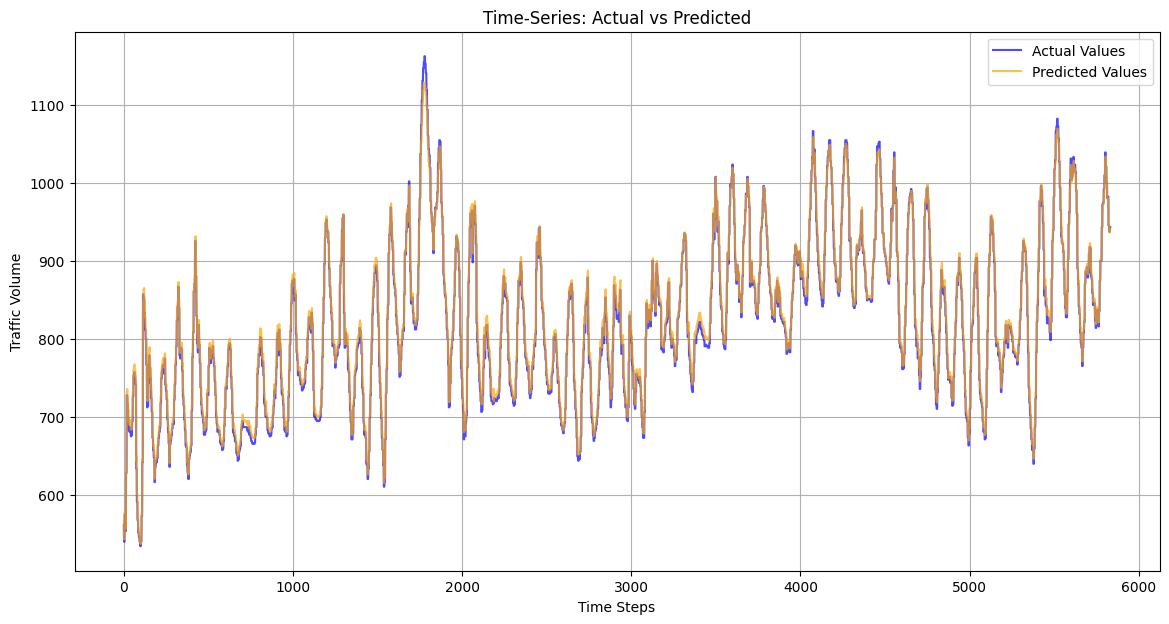

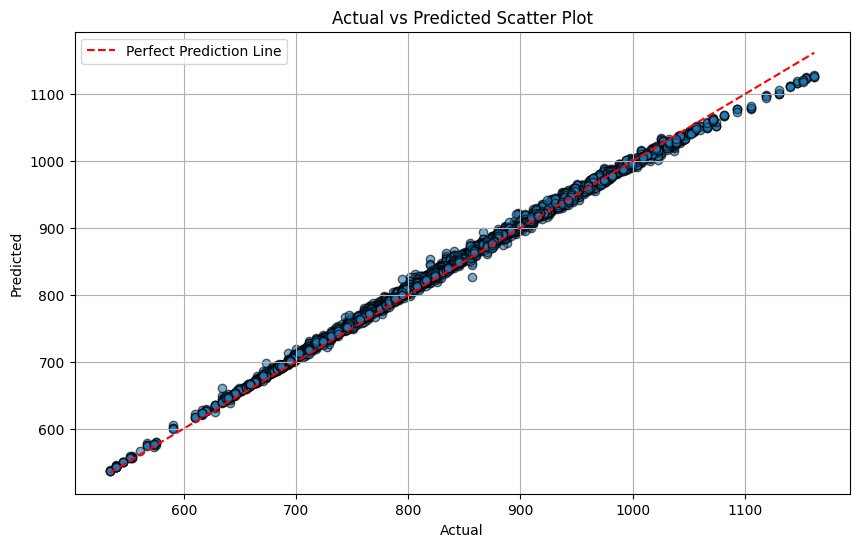

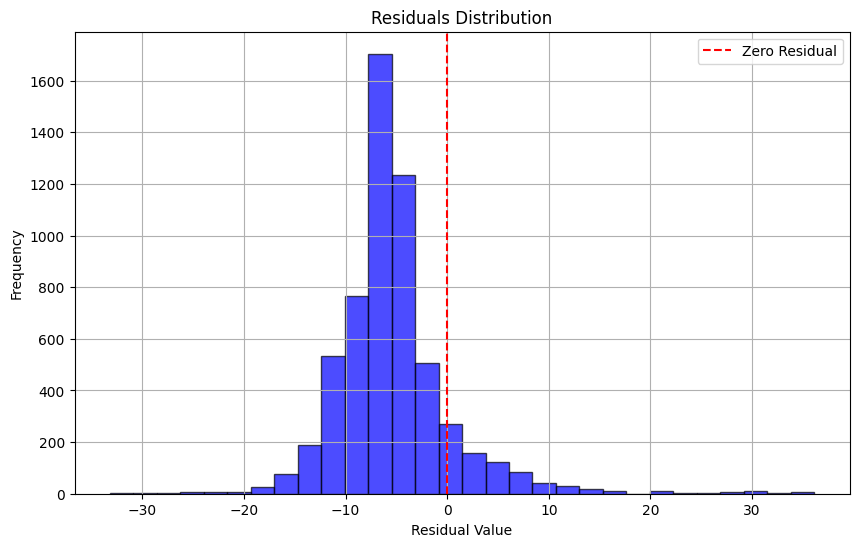

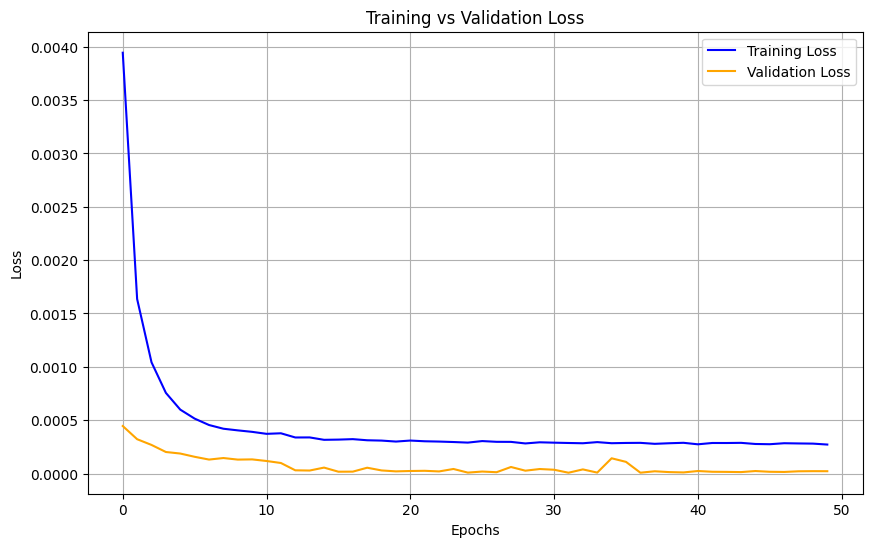

In [7]:
# Residuals
residuals = y_test_actual - test_pred_actual

# Plot: Time-Series Actual vs Predicted
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label="Actual Values", color='blue', alpha=0.7)
plt.plot(test_pred_actual, label="Predicted Values", color='orange', alpha=0.7)
plt.title("Time-Series: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()

# Plot: Actual vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, test_pred_actual, alpha=0.6, edgecolors='k')
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--', label='Perfect Prediction Line')
plt.title("Actual vs Predicted Scatter Plot")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()

# Plot: Residual Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Residual')
plt.title("Residuals Distribution")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Plot: Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
